In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
df = pd.read_csv("housing.csv/housing.csv")
print(df.head())
df.info()

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639

In [29]:
print(df.info())
print(df.isnull().sum())
print(df.describe().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
None
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proxim

In [30]:
%pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [31]:
from sklearn.impute import SimpleImputer

df = df.copy()

imputer = SimpleImputer(strategy="median")
df["total_bedrooms"] = imputer.fit_transform(df[["total_bedrooms"]])

df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [32]:
df['median_income_sq'] = df['median_income'] ** 2


df[['median_income', 'median_income_sq']].head()

,median_income,median_income_sq
0,8.3252,69.308955
1,8.3014,68.913242
2,7.2574,52.669855
3,5.6431,31.844578
4,3.8462,14.793254


In [33]:
from sklearn.model_selection import train_test_split

TARGET = 'median_house_value'

X = df.drop(columns=[TARGET])
y = df[TARGET].copy()

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (16512, 10) Test shape: (4128, 10)


In [34]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numeric_cols  = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols)
    ]
)

In [35]:
from sklearn.linear_model import LinearRegression, Ridge

lr_pipeline = Pipeline([
    ("prepoc", preprocessor),
    ("model", LinearRegression())
])


ridge_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('model', Ridge(alpha=1.0, random_state=42))
])

lr_pipeline.fit(X_train, Y_train)
ridge_pipeline.fit(X_train, Y_train)

,steps,"[('preproc', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [36]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def eval_pipeline(pipe, X, y):
    preds = pipe.predict(X)
    rmse = np.sqrt(mean_squared_error(y, preds))
    mae = mean_absolute_error(y, preds)
    r2 = r2_score(y, preds)
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}, preds

lr_metrics, lr_preds = eval_pipeline(lr_pipeline, X_test, Y_test)
ridge_metrics, ridge_preds = eval_pipeline(ridge_pipeline, X_test, Y_test)

import pandas as pd
comp = pd.DataFrame([lr_metrics, ridge_metrics], index=['LinearRegression', 'Ridge']).T
print(comp)
# also save
comp.T.to_csv('model_comparison.csv', index=True)

      LinearRegression         Ridge
RMSE      70111.513114  70116.196902
MAE       50926.040693  50930.646202
R2            0.624879      0.624828


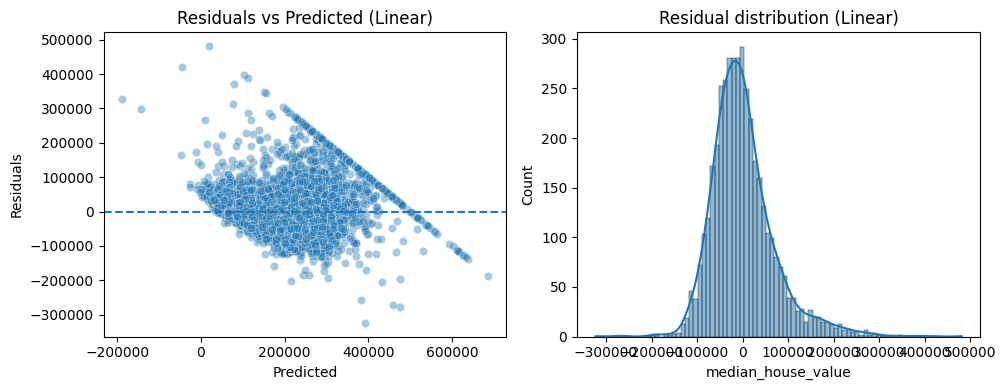

In [39]:
# Cell: residuals and diagnostics
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# residuals for linear model
residuals = Y_test - lr_preds

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.scatterplot(x=lr_preds, y=residuals, alpha=0.4)
plt.axhline(0, linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted (Linear)')

plt.subplot(1,2,2)
sns.histplot(residuals, kde=True)
plt.title('Residual distribution (Linear)')
plt.tight_layout()
plt.show()
